<a href="https://colab.research.google.com/github/craigybaeb/msc-car-gan/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** Craig Pirie
**Date created:** 2021/08/03<br>
**Last modified:** 2021/08/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on the Stanford Car Dataset.

## Setup

In [ ]:
import numpy as np
import tensorflow as tf
import os
import gdown
import tarfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-38eb1b0b-11af-6901-6afc-52fdc6fadf0a)


In [ ]:
!lscpu |grep 'Model name'


Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
!free -h --si | awk  '/Mem:/{print $2}'

26G


# Load the Data

In [ ]:
os.makedirs("cars_gan")
os.makedirs("cars")
os.makedirs("augmented")

url = "http://ai.stanford.edu/~jkrause/car196/car_ims.tgz"
output = "cars_gan/data.tgz"
gdown.download(url, output, quiet=False)

tar = tarfile.open(output, "r:gz")
tar.extractall("/content/cars/")
tar.close()

In [ ]:
#instantiate the ImageDataGenerator class
datagen = ImageDataGenerator(
        rotation_range=40,
        height_shift_range=0.2,
        width_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#loop over the data in batches and this automatically saves the images
i = 0
for batch in datagen.flow_from_directory('/content/cars', batch_size=12,target_size=(64,64),
                          save_to_dir='/content/augmented', save_format='jpg'):
    i += 1
    if i % 1000 == 0:
     print(str(i))

    if i == 16185:
      print("Finished augmentation.")
      break

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/content/augmented", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

## Create a sampling layer

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Build the encoder

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32768)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             98304     
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       147584    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 64)        73792     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 3)         1731      
Total params: 321,411
Trainable params: 321,411
Non-trainable params: 0
_____________________________________________________

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Display a grid of sampled digits

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 64
    channels = 3
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n, channels))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, channels)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

## Train the VAE

In [ ]:
#Default
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=20, batch_size=128)

Epoch 1/20
6069/6069 [==============================] - 107s 15ms/step - loss: 2803.3156 - reconstruction_loss: 2802.2524 - kl_loss: 0.0135
Epoch 2/20
6069/6069 [==============================] - 90s 15ms/step - loss: 2800.9145 - reconstruction_loss: 2801.2905 - kl_loss: 0.0065
Epoch 3/20
6069/6069 [==============================] - 90s 15ms/step - loss: 2800.8031 - reconstruction_loss: 2801.1853 - kl_loss: 0.0027
Epoch 4/20
6069/6069 [==============================] - 90s 15ms/step - loss: 2800.7311 - reconstruction_loss: 2801.1465 - kl_loss: 0.0015
Epoch 5/20
6069/6069 [==============================] - 91s 15ms/step - loss: 2800.7100 - reconstruction_loss: 2801.1062 - kl_loss: 9.6590e-04
Epoch 6/20
6069/6069 [==============================] - 91s 15ms/step - loss: 2800.6977 - reconstruction_loss: 2801.0957 - kl_loss: 7.6605e-04
Epoch 7/20
6069/6069 [==============================] - 90s 15ms/step - loss: 2800.6712 - reconstruction_loss: 2801.0642 - kl_loss: 6.4380e-04
Epoch 8/20
606

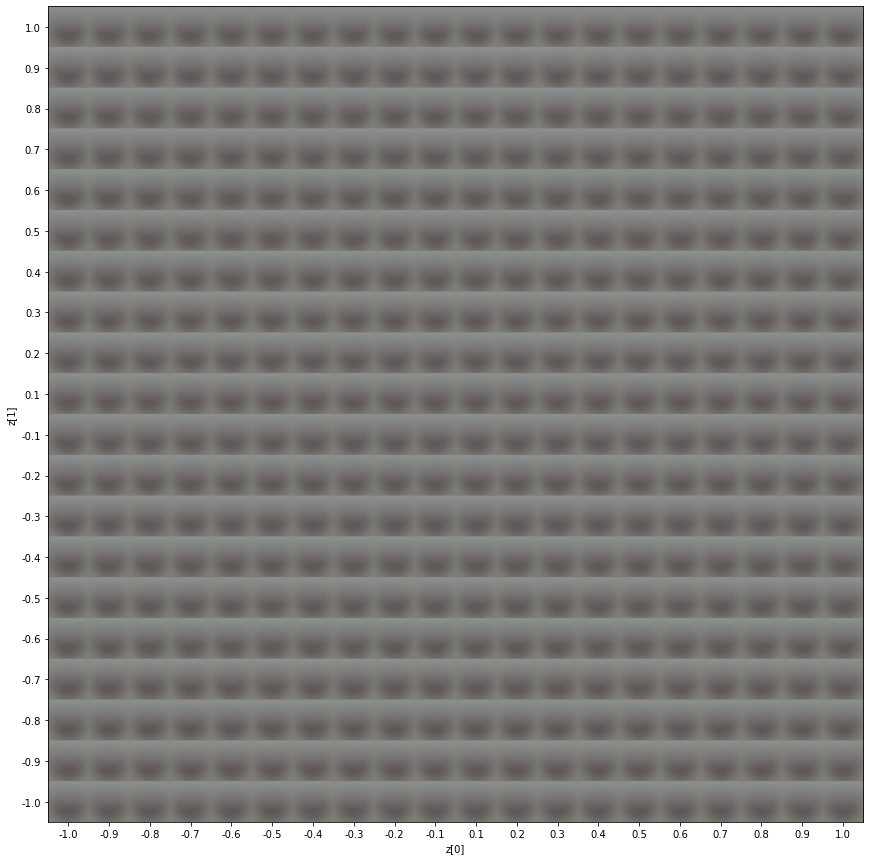

In [ ]:
plot_latent_space(vae)

In [ ]:
#5
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=5, batch_size=128)

Epoch 1/5
6069/6069 [==============================] - 63s 10ms/step - loss: 493.1270 - reconstruction_loss: 489.0694 - kl_loss: 3.9420
Epoch 2/5
6069/6069 [==============================] - 62s 10ms/step - loss: 493.1252 - reconstruction_loss: 489.0568 - kl_loss: 3.9496
Epoch 3/5
6069/6069 [==============================] - 62s 10ms/step - loss: 493.1004 - reconstruction_loss: 489.0451 - kl_loss: 3.9418
Epoch 4/5
6069/6069 [==============================] - 62s 10ms/step - loss: 493.0773 - reconstruction_loss: 489.0243 - kl_loss: 3.9402
Epoch 5/5
6069/6069 [==============================] - 62s 10ms/step - loss: 493.0655 - reconstruction_loss: 489.0225 - kl_loss: 3.9461


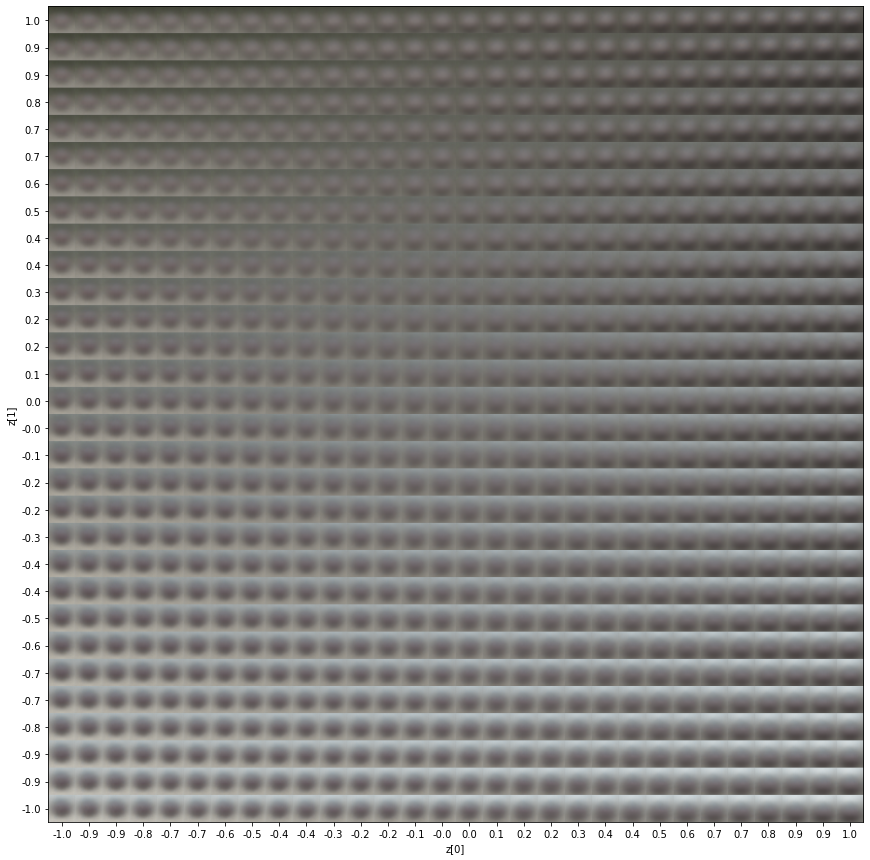

In [ ]:
plot_latent_space(vae)

In [ ]:
#10
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=10, batch_size=128)

Epoch 1/10
6069/6069 [==============================] - 66s 11ms/step - loss: 493.0621 - reconstruction_loss: 489.0004 - kl_loss: 3.9531
Epoch 2/10
6069/6069 [==============================] - 63s 10ms/step - loss: 493.0302 - reconstruction_loss: 488.9838 - kl_loss: 3.9512
Epoch 3/10
6069/6069 [==============================] - 63s 10ms/step - loss: 493.0338 - reconstruction_loss: 488.9669 - kl_loss: 3.9566
Epoch 4/10
6069/6069 [==============================] - 63s 10ms/step - loss: 493.0028 - reconstruction_loss: 488.9398 - kl_loss: 3.9631
Epoch 5/10
6069/6069 [==============================] - 63s 10ms/step - loss: 493.0160 - reconstruction_loss: 488.9203 - kl_loss: 3.9753
Epoch 6/10
6069/6069 [==============================] - 63s 10ms/step - loss: 492.9868 - reconstruction_loss: 488.9041 - kl_loss: 3.9762
Epoch 7/10
6069/6069 [==============================] - 63s 10ms/step - loss: 492.9787 - reconstruction_loss: 488.8843 - kl_loss: 3.9906
Epoch 8/10
6069/6069 [===================

In [ ]:
plot_latent_space(vae)

In [ ]:
#15
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(dataset, epochs=15, batch_size=128)

In [ ]:
plot_latent_space(vae)

# Evaluation

In [ ]:
from IPython.display import Image, display
!pip install pytorch-fid

  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.0-py3-none-any.whl size=10547 sha256=41e01dd58564b2894df54b71d8c03343e87693d70bf7a230ddfc528991fefb29
  Stored in directory: /root/.cache/pip/wheels/6c/0d/de/fa3f925573a4f0162182248c0db291d7ae4d9392898b7cbe5a
Successfully built pytorch-fid


In [ ]:
#Default
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/VAE_LAST'
display(Image('/content/drive/My Drive/Masters/VAE_LAST/0.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST/1.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST/2.png'))

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100% 91.2M/91.2M [00:01<00:00, 51.8MB/s]
tcmalloc: large alloc 3181559808 bytes == 0x560a531d6000 @  0x7fb89489d1e7 0x7fb8922dd46e 0x7fb89232dc7b 0x7fb89232e35f 0x7fb8923d0103 0x5609de9e7010 0x5609de9e6da0 0x5609dea5b2f9 0x5609dea55c35 0x5609de9e873a 0x5609dea56b0e 0x5609dea55c35 0x5609de9e873a 0x5609dea56b0e 0x5609dea56235 0x5609de9e873a 0x5609dea56b0e 0x5609de9e865a 0x5609dea56b0e 0x5609de9e865a 0x5609dea5af40 0x5609dea55c35 0x5609dea55933 0x5609dea53da0 0x5609de9e6ea9 0x5609de9e6da0 0x5609dea5abb3 0x5609dea55c35 0x5609de9e873a 0x5609dea56b0e 0x5609dea55c35
  0% 0/3884 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anythin

In [ ]:
#5
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/VAE_LAST_5'
display(Image('/content/drive/My Drive/Masters/VAE_LAST_5/0.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_5/1.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_5/2.png'))

In [ ]:
#10
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/VAE_LAST_10'
display(Image('/content/drive/My Drive/Masters/VAE_LAST_10/0.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_10/1.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_10/2.png'))

In [ ]:
#15
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/VAE_LAST_15'
display(Image('/content/drive/My Drive/Masters/VAE_LAST_15/0.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_15/1.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_15/2.png'))

In [ ]:
#20
!python -m pytorch_fid '/content/augmented' '/content/drive/My Drive/Masters/VAE_LAST_20'
display(Image('/content/drive/My Drive/Masters/VAE_LAST_20/0.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_20/1.png'))
display(Image('/content/drive/My Drive/Masters/VAE_LAST_20/2.png'))